In [ ]:
!nvidia-smi

Mon Oct 12 13:28:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
df = pd.read_csv('/content/MSFT.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,2015-10-14 00:00:00+00:00,46.68,47.10,46.530,46.65,24697766,42.425017,42.806733,42.288690,42.397751,24697766,0.0,1.0
1,MSFT,2015-10-15 00:00:00+00:00,47.01,47.03,46.530,47.01,27189370,42.724937,42.743114,42.288690,42.724937,27189370,0.0,1.0
2,MSFT,2015-10-16 00:00:00+00:00,47.51,47.54,46.897,47.02,26450334,43.179361,43.206626,42.622237,42.734025,26450334,0.0,1.0
3,MSFT,2015-10-19 00:00:00+00:00,47.62,47.88,47.020,47.42,29387581,43.279334,43.515634,42.734025,43.097564,29387581,0.0,1.0
4,MSFT,2015-10-20 00:00:00+00:00,47.77,47.81,47.020,47.44,30802235,43.415661,43.452015,42.734025,43.115741,30802235,0.0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1257 non-null   object 
 1   date         1257 non-null   object 
 2   close        1257 non-null   float64
 3   high         1257 non-null   float64
 4   low          1257 non-null   float64
 5   open         1257 non-null   float64
 6   volume       1257 non-null   int64  
 7   adjClose     1257 non-null   float64
 8   adjHigh      1257 non-null   float64
 9   adjLow       1257 non-null   float64
 10  adjOpen      1257 non-null   float64
 11  adjVolume    1257 non-null   int64  
 12  divCash      1257 non-null   float64
 13  splitFactor  1257 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.6+ KB


In [4]:
df_close = df.reset_index()['close']
df_close.head()

0    46.68
1    47.01
2    47.51
3    47.62
4    47.77
Name: close, dtype: float64

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [61]:
train = int(len(df_close)*0.6734)
test = len(df_close)-train
train_data , test_data = df_close[0:train,:], df_close[train:len(df_close), :1]
train, test

(846, 411)

In [62]:
def create_dataset(dataset, time_step=1): 
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1): #1000-100-1
		a = dataset[i:(i + time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [63]:
time_step = 99
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [64]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [66]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(99,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [67]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 1s 107ms/step - loss: 0.0130 - val_loss: 0.0774
Epoch 2/100
12/12 [==============================] - 0s 21ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 3/100
12/12 [==============================] - 0s 19ms/step - loss: 6.4094e-04 - val_loss: 0.0027
Epoch 4/100
12/12 [==============================] - 0s 18ms/step - loss: 3.6834e-04 - val_loss: 0.0047
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 2.0871e-04 - val_loss: 0.0073
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 1.8014e-04 - val_loss: 0.0053
Epoch 7/100
12/12 [==============================] - 0s 17ms/step - loss: 1.7441e-04 - val_loss: 0.0059
Epoch 8/100
12/12 [==============================] - 0s 16ms/step - loss: 1.7068e-04 - val_loss: 0.0067
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 1.6956e-04 - val_loss: 0.0079
Epoch 10/100
12/12 [==============================] - 0s 17ms/step - lo

In [68]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

In [69]:
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [70]:
import math
from sklearn.metrics import mean_squared_error
print("Train: ", mean_squared_error(y_train,train_predict))
print("Test: ", mean_squared_error(ytest, y_pred))

Train:  6750.2889918168385
Test:  25686.768600531617


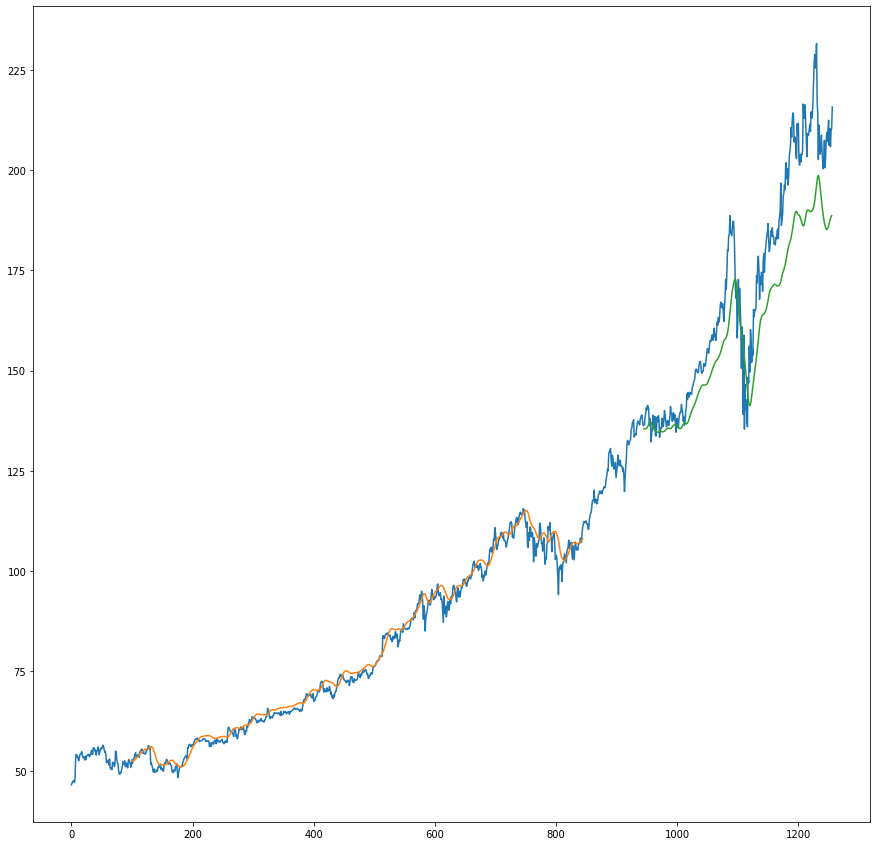

In [72]:
look_back= 99
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = y_pred
# plot baseline and predictions
plt.figure(figsize=(15, 15))
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [73]:
len(test_data)

411

In [74]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 70)

In [75]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
from numpy import array

lst_output=[]
n_steps=99
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

In [78]:
len(df_close)

1257

In [84]:
day_new=np.arange(1,100)
day_pred=np.arange(100,131)

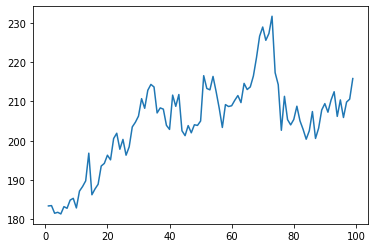

In [86]:
plt.plot(day_new,scaler.inverse_transform(df_close[1158:]))